# [E-04] 멋진 작사가 만들기

## 1. 데이터 다운로드

In [1]:
# $ mkdir -p ~/aiffel/lyricist/models
# $ ln -s ~/data ~/aiffel/lyricist/data

## 2. 데이터 읽어오기

In [2]:
import glob
import os, re

import numpy as np
import tensorflow as tf

In [3]:
txt_file_path = os.getenv('HOME') + '/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path) # txt 파일이 여러 개이므로

raw_corpus = []

# 여러 개의 txt 파일을 모두 읽어 raw_corpus에 담기
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines() # 라인 단위로
        raw_corpus.extend(raw)

print('데이터 크기: ', len(raw_corpus))
print('Examples:\n', raw_corpus[:3])

데이터 크기:  187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


✔️여기서 파이썬 extend 함수는 append와 비슷하지만 가장 바깥쪽 iterable의 모든 항목을 넣는다.

## 3. 데이터 정제
- 앞에서 만든 preprocess_sentence() 함수를 이용해 정제하기
- 토큰 개수 15개 넘어가는 문장(지나치게 긴 문장)은 제외하기

#### 정규표현식(Regex) 이용
1. 소문자로 바꾸고, 양쪽에 공백 지우기
2. 특수문자의 양쪽에 공백 넣기
3. 여러 개의 공백 -> 하나의 공백으로
4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾸기
5. 다시 양쪽 공백 지우기
6. 문장 시작에는 < start >를, 끝에는 < end >를 추가

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    
    return sentence

In [5]:
# 예시로 필터링이 어떻게 되는지 확인해보기
ex = "This @_is ;;;sample        sentence."
preprocess_sentence(ex)

'<start> this is sample sentence . <end>'

#### 🔮토큰 개수가 15개를 넘어가는 문장은 제외해야 한다.
#### 🔮이를 위해 필터링 된 단어를 split으로 나눈 뒤 15개 초과한 문장은 제거하도록 하자

In [6]:
# 이런 식으로 개수 셀 수 있음
len(preprocess_sentence(ex).split())

7

In [7]:
corpus = [] # 정제된 문자 모으기

for sentence in raw_corpus:
    # 원하지 않는 문장 건너 뛰기
    if len(sentence) == 0: continue
    if sentence[-1] == ':': continue
    
    # 정제
    preprocessed_sentence = preprocess_sentence(sentence)
    # 토큰 개수가 15개 넘어가는 경우 건너 뛰기
    if len(preprocessed_sentence.split()) > 15: continue
        
    # 담아주기
    corpus.append(preprocessed_sentence)

corpus[:5]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>']

잘 정제됨을 확인할 수 있다.

## 토큰화
- 단어장의 크기는 12,000장 이상으로 설정하기
- maxlen으로 문장 최대 길이 설정

In [8]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
                    num_words=12000, # 12000개가 담긴 단어장
                    filters=' ',
                    oov_token="<unk>" # 포함되지 못하는 단어는 <unk>로 바꿔주기
    )
    
    tokenizer.fit_on_texts(corpus) # 문자 데이터 입력 받아 리스트 형태로 반환

    # 텍스트 안의 단어를 숫자 시퀀스(tensor)로 변환하기
    tensor = tokenizer.texts_to_sequences(corpus)
    
    # pad_sequences의 padding을 통해 시퀀스 길이 일정하게 맞춰주기
    # 문장 앞에 길이 맞추고 싶다면 padding='pre' 입력
    # maxlen으로 문장 최대 길이 15로 설정
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=15)
    
    print(tensor, '\n', tokenizer)
    return tensor, tokenizer


tensor, tokenizer = tokenize(corpus)

[[   2   50    4 ...    0    0    0]
 [   2   15 2967 ...    0    0    0]
 [   2   33    7 ...   46    3    0]
 ...
 [   2    4  118 ...    0    0    0]
 [   2  258  194 ...   12    3    0]
 [   2    7   34 ...    0    0    0]] 


#### ✔️표준 정규분포를 이용하여 maxlen 설정하는 방법
max_tokens를 mean + 2*std 로 계산, 즉 이상치를 제외한 약 95% 이내의 값을 최대 값으로 잡음

In [9]:
#total_data_text = list(tensor)
#     num_tokens = [len(tokens) for tokens in total_data_text]
#     max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
#     maxlen = int(max_tokens)
      # corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰짐
#     tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post', maxlen=maxlen)

In [10]:
print(len(tensor), len(corpus))

156013 156013


문장이 잘 정제되었나 확인해보기

In [11]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인
        
    print(sentence)

Now I've heard there was a secret chord
That David played, and it pleased the Lord
But you don't really care for music, do you?
It goes like this
The fourth, the fifth
The minor fall, the major lift
The baffled king composing Hallelujah Hallelujah
Hallelujah
Hallelujah
Hallelujah Your faith was strong but you needed proof


단어 사전 구축 확인해보기

In [12]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


### 입력 데이터인 source sentence와 출력 데이터인 target sentence 생성

In [13]:
# tensor[a][b] == tensor[a, b]
src_input = tensor[:, :-1] # <end> 토큰 제외
tgt_input = tensor[:, 1:] # <start> 토큰 제외

print(src_input[0])
print(tgt_input[0])

[   2   50    4   95  303   62   53    9  946 6263    3    0    0    0]
[  50    4   95  303   62   53    9  946 6263    3    0    0    0    0]


In [14]:
print(src_input.shape, tgt_input.shape)

(156013, 14) (156013, 14)


## 4. 평가 데이터셋 분리

In [15]:
from sklearn.model_selection import train_test_split

# 총 데이터의 20%를 평가 데이터셋으로 사용
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                          tgt_input,
                                                          test_size=0.2,
                                                          random_state=42,
                                                          shuffle=True)

In [16]:
print("Source Train: ", enc_train.shape)
print("Target Train: ", dec_train.shape)

Source Train:  (124810, 14)
Target Train:  (124810, 14)


In [17]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

# tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함해 120001개
VOCAB_SIZE = tokenizer.num_words + 1

# train 데이터셋 만들기 (자세히 알수록 중요함)
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
print(train_dataset)

# test 데이터셋 만들기
test_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
test_dataset = test_dataset.shuffle(BUFFER_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
print(test_dataset)

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>
<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>


In [18]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
    
    def call(self, x): # 순환 신경망의 구조가 잘 나타나는듯!
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        return out

# 적정 조절 필요
embedding_size = 1024
hidden_size = 2048
lyrics_model = TextGenerator(tokenizer.num_words + 1, embedding_size, hidden_size)

#### 🔮embedding_size, hidden_size 무작정 늘리면 좋을까? No
✔️embedding_size: 단어가 추상적으로 표현되는 크기 <br/>
✔️hidden_size: 출력 벡터의 차원 수

In [19]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법
for src_sample, tgt_sample in train_dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어보기
lyrics_model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-4.2884832e-04, -1.9075633e-04, -3.6576070e-04, ...,
          4.7980252e-04, -1.6787158e-04,  2.1608412e-04],
        [-5.9164554e-04, -5.1411055e-04, -5.7025120e-04, ...,
          1.1598979e-03, -8.5568882e-04,  6.1838113e-04],
        [-6.4624008e-04, -9.7006297e-04, -8.4429682e-04, ...,
          1.3000256e-03, -1.3890498e-03,  5.2444125e-04],
        ...,
        [ 1.1307108e-03,  7.9232402e-04, -3.9909143e-04, ...,
         -2.4010043e-03,  3.3250733e-04,  4.4830627e-04],
        [ 1.7929948e-03,  1.5372628e-03, -2.4023495e-04, ...,
         -3.0462020e-03,  4.4854783e-04,  5.4578483e-04],
        [ 2.4624546e-03,  2.4173423e-03, -1.3877306e-04, ...,
         -3.6218569e-03,  5.6286715e-04,  6.2903221e-04]],

       [[-4.2884832e-04, -1.9075633e-04, -3.6576070e-04, ...,
          4.7980252e-04, -1.6787158e-04,  2.1608412e-04],
        [-8.5755886e-04, -1.1793675e-04, -6.2126142e-04, ...,
          1.0074893e-03, 

In [20]:
lyrics_model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  12289024  
_________________________________________________________________
lstm (LSTM)                  multiple                  25174016  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 95,615,713
Trainable params: 95,615,713
Non-trainable params: 0
_________________________________________________________________


## 5. 인공지능 만들기

In [21]:
optimizer = tf.keras.optimizers.Adam()

# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

epoch = 7 # 에포크 조절하기

lyrics_model.compile(loss=loss, 
                     optimizer=optimizer, 
                     metrics=['accuracy']) # 정확성 판단

lyrics_history = lyrics_model.fit(train_dataset, # 훈련 데이터
                                  validation_data=test_dataset, # 평가 데이터
                                  epochs=epoch)

Epoch 1/10
487/487 [==============================] - 261s 528ms/step - loss: 3.2213 - accuracy: 0.5079 - val_loss: 2.8676 - val_accuracy: 0.5325
Epoch 2/10
487/487 [==============================] - 269s 552ms/step - loss: 2.6835 - accuracy: 0.5473 - val_loss: 2.6121 - val_accuracy: 0.5564
Epoch 3/10
487/487 [==============================] - 271s 556ms/step - loss: 2.3601 - accuracy: 0.5773 - val_loss: 2.4312 - val_accuracy: 0.5801
Epoch 4/10
487/487 [==============================] - 272s 558ms/step - loss: 2.0418 - accuracy: 0.6160 - val_loss: 2.2974 - val_accuracy: 0.6038
Epoch 5/10
487/487 [==============================] - 284s 584ms/step - loss: 1.7422 - accuracy: 0.6615 - val_loss: 2.2048 - val_accuracy: 0.6250
Epoch 6/10
487/487 [==============================] - 284s 583ms/step - loss: 1.4798 - accuracy: 0.7082 - val_loss: 2.1451 - val_accuracy: 0.6447
Epoch 7/10
487/487 [==============================] - 284s 582ms/step - loss: 1.2721 - accuracy: 0.7498 - val_loss: 2.1207 -

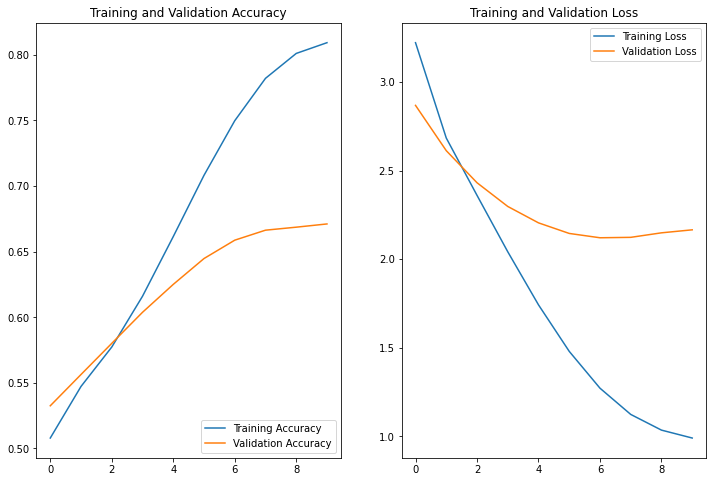

In [22]:
import matplotlib.pyplot as plt

acc = lyrics_history.history['accuracy']
val_acc = lyrics_history.history['val_accuracy']

loss = lyrics_history.history['loss']
val_loss = lyrics_history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (12, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 에포크=8부터 val loss가 다시 증가하기 시작했다. 조금 줄일 필요성이 있어 보인다.

In [23]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    
    # 테스트를 위해 입력받은 init_sentence도 텐서로 변환하기
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]
    
    # 단어 하나씩 예측해 문장 만들기
        # 1. 입력받은 문장의 텐서 입력
        # 2. 예측된 값 중 가장 높은 확률인 word index 뽑기
        # 3. 2에서 예측된 word index를 문장 뒤에 붙이기
        # 4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성 끝내기

    while True:
        predict = model(test_tensor) # 1
        
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] # 2
        
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1) # 3

        if predict_word.numpy()[0] == end_token: break # 4
        if test_tensor.shape[1] >= max_len: break
    
    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환하기
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "
    
    return generated


In [24]:
generate_text(lyrics_model, tokenizer, init_sentence="<start> i love", max_len=20)

'<start> i love you so much , i love you so much <end> '

In [25]:
generate_text(lyrics_model, tokenizer, init_sentence="<start> i can see", max_len=20)

'<start> i can see it through the lens of my <unk> <end> '

In [26]:
generate_text(lyrics_model, tokenizer, init_sentence="<start> They say", max_len=20)

'<start> they say i m losing my mind <end> '

In [27]:
generate_text(lyrics_model, tokenizer, init_sentence="<start> The sky", max_len=20)

'<start> the sky is low , the clouds are mean , <end> '

*****

# 🧤회고

평소 자연어처리에 관심이 있었는데 이번 노드를 통해 다뤄볼 수 있어서 유익한 시간이었다. 내가 입력한 짧은 문장으로 멋진 작사를 해줄 수 있다는 점이 재밌었고, 다음 번엔 좀 더 좋은 예제로 더 긴 문장을 만들어보고 싶다.

#### ✔️결과
- 같은 모델을 돌려보면 만들어지는 문장이 계속해서 바뀌는데 길이가 줄어들 때도 있고, 말이 안 되는 문장이 나오는 경우도 있었다. loss값도 돌릴 때마다 증가해서 난처한 부분도 존재했다.

#### ✔️정규표현식
- 예전에도 정규표현식을 한 번 다뤄본 적이 있는데 느낀 점은 꽤나 까다롭다는 것이다. 내가 원하는 부분을 세세하게 따져가며 조건을 줘야할 것 같다.

#### ✔️embedding_size, hidden_state
- 이 둘의 크기를 조절해나가며 모델을 훈련했는데, 예제에 나온 256, 1024로는 val_loss가 2.2 이하로 떨어지지 않아 크기를 키워보았다. hidden_state를 너무 키우면 훈련 시간이 상상 이상으로 증가하였고, 성능도 그만큼 좋게 나오진 않았다. 이 두 파라미터의 크기를 너무 키워도 좋지 않구나를 깨달았다.

#### ✔️train, val 데이터
- 앞서 예제에는 dataset을 train 데이터와 val 데이터로 분리하는 부분이 없어 이를 어떻게 이용해야하는지 감이 안 잡혔다. 결과적으로 두 개의 데이터셋을 만들어 모델 훈련 시 두 가지 데이터를 모두 넣어주면 된다는 것을 깨달았다.

#### ✔️dataset
- 이 과정에서 굳이 dataset으로 만들어주는 이유는 무엇일까? 생각해보았는데 노드 설명에도 나와있듯이 텐서플로우를 활용할 때는 이 데이터셋 객체를 생성하는 방법을 흔히 사용한다 한다. 여러 편의성이 있다고 하니 참고해야겠다.

#### ✔️토큰 개수 조절
- 본 예제는 토큰의 개수가 15개가 넘어가는 문장은 학습에서 제외를 시켜야했다. 결과적으로 파이썬의 split 함수를 이용해len(preprocessed_sentence.split()) > 15 인 경우 건너 뛰어라 라는 문장을 추가해 구현할 수 있었다.

#### ✔️max_len
- 나는 위에서 max_len을 15를 주었지만 찾아보니 max_tokens를 np.mean(num_tokens) + 2 * np.std(num_tokens) 로 구하여 max_len = len(max_tokens)으로 문장 길이를 조절하는 코드가 있었다. 처음에는 무슨 말인지 이해가 가지 않았는데 정규분포의 개념을 떠올리니 쉽게 이해할 수 있었다. 좋은 예시인 것 같다.

#### 🔮🔮
- 토큰 개수를 15개로 제한하는 부분에서 (1) split 함수를 사용해 애초에 15개가 넘어가는 토큰을 가진 문장은 배제시키는 방법과 (2) max_len=15를 이용해 문장 자체를 15개로 자르는 두 가지 방법이 있었다.
- 하지만 두 번째 방법은 길이가 긴 문장이 15번째에서 도중에 잘릴 위험이 있다. 따라서 안정적으로 첫 번째 방법을 이용하는 것이 좋다고 판단하였고, 혹시 몰라 max_len도 15로 맞춰주었다.

NLP를 다뤄볼 수 있는 재미있는 노드였고, 앞으로 좀 더 공부해보고싶다!